# Brain Tumor Detection Using a Convolutional Neural Network

In [1]:
print('hello')

hello


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-dataset/no/no/34 no.jpg
/kaggle/input/sample-dataset/no/no/N20.JPG
/kaggle/input/sample-dataset/no/no/N1.JPG
/kaggle/input/sample-dataset/no/no/49 no.jpg
/kaggle/input/sample-dataset/no/no/N15.jpg
/kaggle/input/sample-dataset/no/no/No18.jpg
/kaggle/input/sample-dataset/no/no/31 no.jpg
/kaggle/input/sample-dataset/no/no/no 6.jpg
/kaggle/input/sample-dataset/no/no/3 no.jpg
/kaggle/input/sample-dataset/no/no/no 5.jpeg
/kaggle/input/sample-dataset/no/no/no 1.jpg
/kaggle/input/sample-dataset/no/no/26 no.jpg
/kaggle/input/sample-dataset/no/no/N26.JPG
/kaggle/input/sample-dataset/no/no/N5.jpg
/kaggle/input/sample-dataset/no/no/6 no.jpg
/kaggle/input/sample-dataset/no/no/No21.jpg
/kaggle/input/sample-dataset/no/no/17 no.jpg
/kaggle/input/sample-dataset/no/no/No22.jpg
/kaggle/input/sample-dataset/no/no/29 no.jpg
/kaggle/input/sample-dataset/no/no/46 no.jpg
/kaggle/input/sample-dataset/no/no/32 no.jpg
/kaggle/input/sample-dataset/no/no/42 no.jpg
/kaggle/input/sample-dataset/

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=70ef95072fdcdf9b9bf1b2e38f6865f2c39474d7a51a111f4b1932a24ea5a54a
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


## Import Necessary Modules

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [4]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

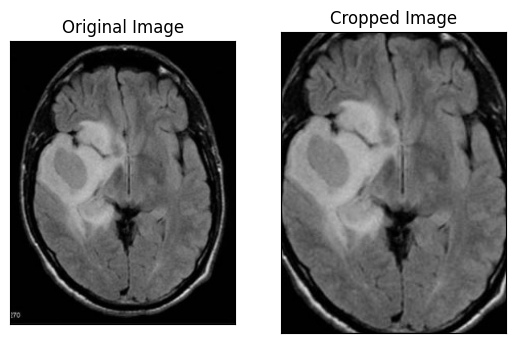

In [5]:
ex_img = cv2.imread('/kaggle/input/sample-dataset/yes/yes/Y256.JPG')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [6]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [7]:
#augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = '/kaggle/input/sample-dataset/yes/yes' 
augmented_no = '/kaggle/input/sample-dataset/no/no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [8]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

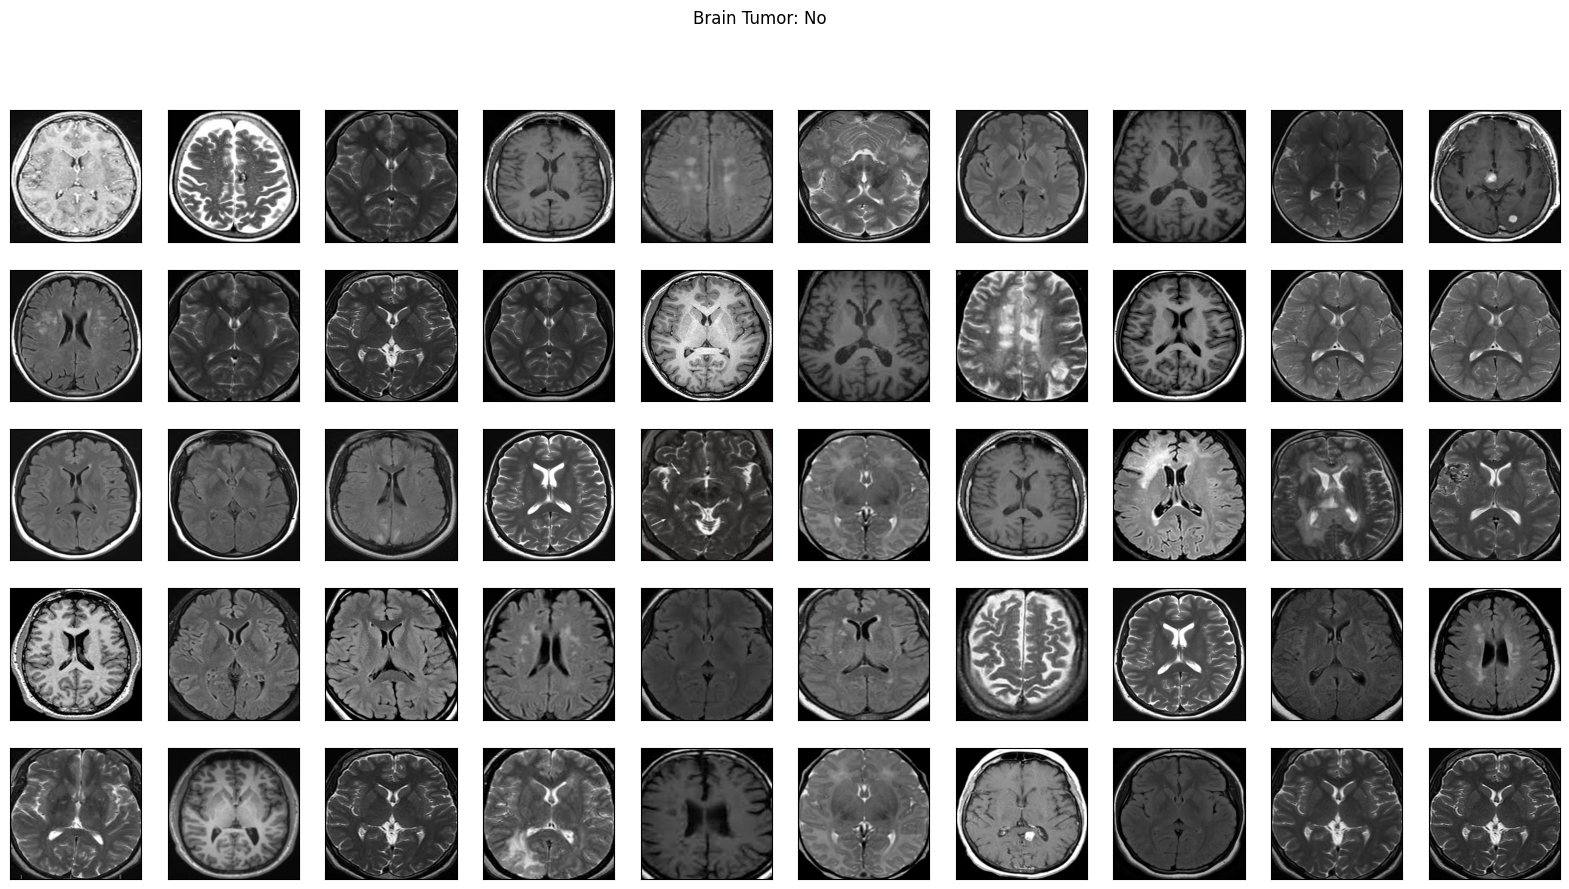

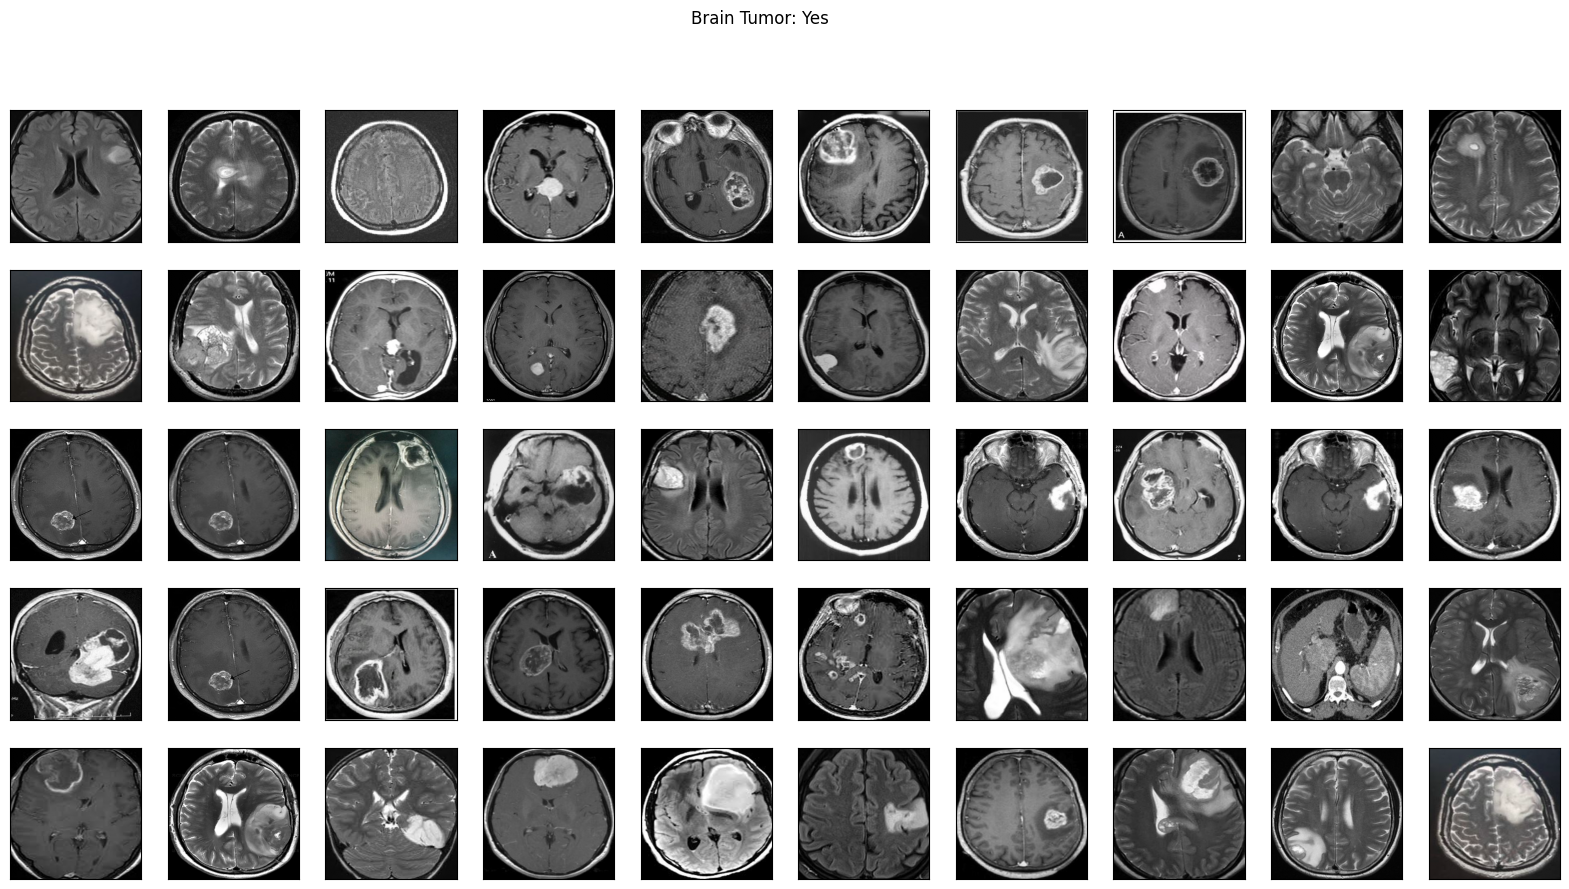

In [9]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [10]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [12]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 177
number of development examples = 38
number of test examples = 38
X_train shape: (177, 240, 240, 3)
Y_train shape: (177, 1)
X_val (dev) shape: (38, 240, 240, 3)
Y_val (dev) shape: (38, 1)
X_test shape: (38, 240, 240, 3)
Y_test shape: (38, 1)


Some helper functions:

In [13]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [14]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

In [15]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [16]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [17]:
model = build_model(IMG_SHAPE)

In [18]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model:

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [21]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath = "cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

## Train the model

In [22]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10


I0000 00:00:1729765567.326887     120 service.cc:145] XLA service 0x78cd6c0056a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729765567.326939     120 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729765567.326943     120 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729765570.615867     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.5815 - loss: 1.5853
Epoch 1: val_accuracy improved from -inf to 0.65789, saving model to cnn-parameters-improvement-01-0.66.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 538ms/step - accuracy: 0.5824 - loss: 1.5787 - val_accuracy: 0.6579 - val_loss: 0.6330
Epoch 2/10
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6168 - loss: 0.7819
Epoch 2: val_accuracy did not improve from 0.65789
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5923 - loss: 0.7961 - val_accuracy: 0.6579 - val_loss: 0.6258
Epoch 3/10
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7255 - loss: 0.7115
Epoch 3: val_accuracy did not improve from 0.65789
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7168 - loss: 0.7309 - val_accuracy: 0.6579 - val_loss: 0.6544
Epoch 4/10
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6252 - loss: 0.6348
Epoch 4: val_accuracy did not improve from 0.65789
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6322 - loss: 0.6276 

Let's train for a few more epochs:

In [23]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8870 - loss: 0.2999
Epoch 1: val_accuracy did not improve from 0.78947
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8934 - loss: 0.2902 - val_accuracy: 0.7895 - val_loss: 0.5842
Epoch 2/3
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9178 - loss: 0.2489
Epoch 2: val_accuracy did not improve from 0.78947
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9187 - loss: 0.2458 - val_accuracy: 0.7895 - val_loss: 0.5616
Epoch 3/3
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9614 - loss: 0.2056
Epoch 3: val_accuracy improved from 0.78947 to 0.81579, saving model to cnn-parameters-improvement-03-0.82.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9595 - loss: 0.2067 - val_accuracy: 0.8158 - val_loss: 0.5721
Elapsed time: 0:0:1.4


In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9400 - loss: 0.2239
Epoch 1: val_accuracy improved from 0.81579 to 0.84211, saving model to cnn-parameters-improvement-01-0.84.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9414 - loss: 0.2221 - val_accuracy: 0.8421 - val_loss: 0.5571
Epoch 2/3
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9685 - loss: 0.1822
Epoch 2: val_accuracy did not improve from 0.84211
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9662 - loss: 0.1803 - val_accuracy: 0.8158 - val_loss: 0.5449
Epoch 3/3
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9753 - loss: 0.1663
Epoch 3: val_accuracy did not improve from 0.84211
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9711 - loss: 0.1663 - val_accuracy: 0.7632 - val_loss: 0.5344
Elapsed time: 0:0:1.4


In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9166 - loss: 0.2091
Epoch 1: val_accuracy did not improve from 0.84211
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9194 - loss: 0.2062 - val_accuracy: 0.8421 - val_loss: 0.5572
Epoch 2/3
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9464 - loss: 0.1923
Epoch 2: val_accuracy did not improve from 0.84211
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9455 - loss: 0.1875 - val_accuracy: 0.7632 - val_loss: 0.5409
Epoch 3/3
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9829 - loss: 0.1401
Epoch 3: val_accuracy did not improve from 0.84211
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9846 - loss: 0.1382 - val_accuracy: 0.7895 - val_loss: 0.5253
Elapsed time: 0:0:1.3


In [26]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9571 - loss: 0.1627
Epoch 1: val_accuracy did not improve from 0.84211
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9597 - loss: 0.1613 - val_accuracy: 0.8421 - val_loss: 0.5430
Epoch 2/5
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9944 - loss: 0.1272
Epoch 2: val_accuracy did not improve from 0.84211
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9928 - loss: 0.1279 - val_accuracy: 0.8421 - val_loss: 0.5459
Epoch 3/5
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9864 - loss: 0.1075
Epoch 3: val_accuracy did not improve from 0.84211
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9854 - loss: 0.1112 - val_accuracy: 0.8421 - val_loss: 0.5231
Epoch 4/5
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9987 - loss: 0.0862
Epoch 4: val_accuracy did not improve from 0.84211
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9975 - loss: 0.0903 - val_accuracy: 0.8158 - val_loss: 0.5128
Epoch 5/5
5/

In [27]:
history = model.history.history

In [28]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [29]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

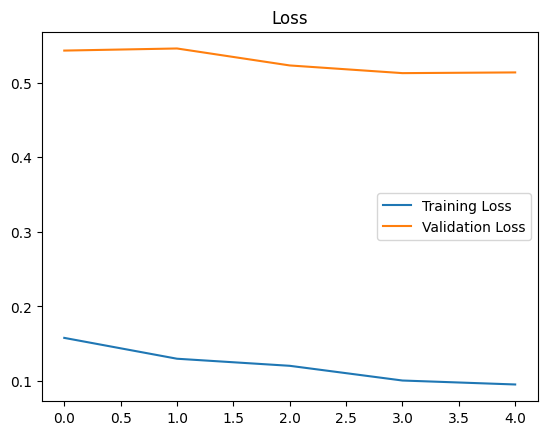

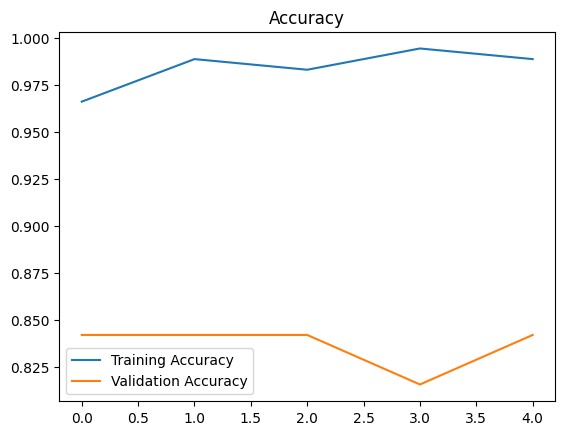

In [30]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [32]:
best_model = load_model(filepath='/kaggle/working/cnn-parameters-improvement-09-0.79.keras')

In [33]:
best_model.metrics_names

['loss', 'compile_metrics']

Evaluate the best model on the testing data:

In [34]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.5455 - loss: 0.6378


### Accuracy of the best model on the testing data:

In [35]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.6369876265525818
Test Accuracy = 0.5526315569877625


### F1 score for the best model on the testing data:

In [36]:
y_test_prob = best_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


In [37]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.6382978723404256


Let's also find the f1 score on the validation data:

In [38]:
y_val_prob = best_model.predict(X_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [39]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8571428571428571


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [40]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [41]:
# the whole data
data_percentage(y)

Number of examples: 253
Percentage of positive examples: 61.26482213438735%, number of pos examples: 155
Percentage of negative examples: 38.73517786561265%, number of neg examples: 98


In [42]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 177
Percentage of positive examples: 62.14689265536723%, number of pos examples: 110
Percentage of negative examples: 37.85310734463277%, number of neg examples: 67
Validation Data:
Number of examples: 38
Percentage of positive examples: 65.78947368421052%, number of pos examples: 25
Percentage of negative examples: 34.21052631578947%, number of neg examples: 13
Testing Data:
Number of examples: 38
Percentage of positive examples: 52.63157894736842%, number of pos examples: 20
Percentage of negative examples: 47.36842105263158%, number of neg examples: 18


In [43]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
best_model = load_model('/kaggle/working/cnn-parameters-improvement-09-0.79.keras')

# Function to preprocess the image
def preprocess_image(image_path, img_size=(240, 240)):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return None

    # Resize to match the input shape of the model
    image_resized = cv2.resize(image, img_size)
    
    # Normalize pixel values to be between 0 and 1 (assuming the model was trained this way)
    image_resized = image_resized / 255.0
    
    # Expand dimensions to add batch size (1, img_size[0], img_size[1], 3)
    image_resized = np.expand_dims(image_resized, axis=0)
    
    return image_resized

# Function to predict tumor presence
def predict_tumor(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    if image is None:
        return
    
    # Make a prediction using the trained model
    prediction_prob = best_model.predict(image)
    
    # Interpret the result (assuming binary classification: 0 = No tumor, 1 = Tumor)
    prediction = np.argmax(prediction_prob, axis=1)[0]
    
    if prediction == 1:
        print(f"The model predicts that the image at {image_path} has a tumor.")
    else:
        print(f"The model predicts that the image at {image_path} does NOT have a tumor.")

# Example usage
image_path = '/kaggle/input/sample-dataset/no/no/19 no.jpg'  # Define the image path
predict_tumor(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
The model predicts that the image at /kaggle/input/sample-dataset/no/no/19 no.jpg does NOT have a tumor.


In [44]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
best_model = load_model('/kaggle/working/cnn-parameters-improvement-09-0.79.keras')

# Function to preprocess the image
def preprocess_image(image_path, img_size=(240, 240)):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return None

    # Resize to match the input shape of the model
    image_resized = cv2.resize(image, img_size)
    
    # Normalize pixel values to be between 0 and 1
    image_resized = image_resized / 255.0
    
    # Expand dimensions to add batch size (1, img_size[0], img_size[1], 3)
    image_resized = np.expand_dims(image_resized, axis=0)
    
    return image_resized

# Function to predict tumor presence
def predict_tumor(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    if image is None:
        return
    
    # Make a prediction using the trained model
    prediction_prob = best_model.predict(image)
    
    # Assuming the model outputs a probability for the "tumor" class, check if it's above 0.5
    if prediction_prob[0][0] > 0.5:
        print(f"The model predicts that the image at {image_path} has a tumor. (Confidence: {prediction_prob[0][0]:.2f})")
    else:
        print(f"The model predicts that the image at {image_path} does NOT have a tumor. (Confidence: {prediction_prob[0][0]:.2f})")

# Example usage
image_path = '/kaggle/input/sample-dataset/yes/yes/Y192.JPG'  # Define the image path
predict_tumor(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
The model predicts that the image at /kaggle/input/sample-dataset/yes/yes/Y192.JPG has a tumor. (Confidence: 0.69)
